In [1]:
import os
import pandas as pd
import numpy as np
# coparing it statistically
import scipy.stats as stats
import matplotlib.pyplot as plt


Setting up the enviornment

In [2]:
### this cell separates the subjects and session of the frame displacement data
abspath = os.path.abspath('__file__')
dname = os.path.dirname(os.path.dirname(abspath))
os.environ["ROOTDIR"] = dname  # seth path
rootdir = os.environ["ROOTDIR"]

metadata_path = os.path.join(rootdir, 'metadata')

Reading the subjects in the first wave

In [3]:
data = pd.read_csv(os.path.join(metadata_path,'sub_list_fd.csv'))
## solitting the file name to sub ses func and 
sub_ses_df = data['file_name'].str.split('/', expand=True).drop([0,1,2,3,4,5,8,9],axis=1)
## remove the file name of the actual data remaining the fd checking axis =1 means collunm
fd_df = data.drop(['file_name'],axis=1)
#concatenating the final data
fd_data = pd.concat([sub_ses_df,fd_df],axis=1)
fd_data = fd_data.rename(columns={6:'sub_id' , 7:'session'})
fd_data.drop(fd_data[fd_data.session == 'ses-3'].index, inplace=True)
fd_data.drop(fd_data[fd_data.session == 'ses-2'].index, inplace=True)
fd_data = fd_data.sort_values("sub_id") 

###### IMPORTANT: here false is optimal in both conditions

In [4]:
#READING THE DATA
confund_data = pd.read_csv(os.path.join(metadata_path, 'checaCONFOUNDS.txt'), sep= " ")
sub_ids = pd.read_csv(os.path.join(metadata_path, 'subjects.txt'),sep=' ')
#remove the unnecessary file names and indexes
sub_ids = sub_ids['FILE_NAME'].str.split('/', expand=True).drop([2,3],axis=1)
confund_data = confund_data.drop(['index','V2'], axis=1)

conf_sub_data = pd.concat([sub_ids, confund_data['V1']==181], axis=1)
conf_sub_data = conf_sub_data.rename({0 : 'sub_id', 1:'session'}, axis=1)
#dopping other sessions / wave
conf_sub_data.drop(conf_sub_data[conf_sub_data.session == 'ses-3'].index, inplace=True)
conf_sub_data.drop(conf_sub_data[conf_sub_data.session == 'ses-2'].index, inplace=True)
conf_sub_data

,sub_id,session,V1
0,sub-00003,ses-1,True
2,sub-00008,ses-1,True
3,sub-00015,ses-1,True
4,sub-00016,ses-1,True
7,sub-00019,ses-1,True
...,...,...,...
1514,sub-02496,ses-1,True
1519,sub-02502,ses-1,True
1522,sub-02507,ses-1,True
1523,sub-02509,ses-1,True


In [ ]:
df2 = pd.merge(fd_data, conf_sub_data, on=['sub_id','session'])
df2 = df2.drop(['session'], axis=1)
df2

,sub_id,fd_mean,fd_mean_value,fd_count_high,fd_count_high_value,V1
0,sub-00003,False,0.072094,False,3,True
1,sub-00008,True,0.311252,True,51,True
2,sub-00015,False,0.118437,False,3,True
3,sub-00016,True,0.587256,True,101,True
4,sub-00019,False,0.129256,False,17,True
...,...,...,...,...,...,...
663,sub-02496,False,0.131778,True,21,True
664,sub-02502,False,0.157067,False,16,True
665,sub-02507,False,0.096652,False,8,True
666,sub-02509,False,0.092963,False,2,True


Uploading sociodemografic and psicometric data and doing random sample imputation for the missing data

In [6]:
#Reading the data
socidemo_path = os.path.join(rootdir,'fMRI_INPD_sociodemographic')
socio_psi = pd.read_excel(os.path.join(socidemo_path,'banco_angelo.xlsx'))

dados_clinicos = socio_psi[['ident', 'gender', 'abepscore','trauma_exp', 'age', 'DQ','subjectid', 'cape_tot', 'cape_PA_score', 'cape_PI_score', 'cape_BE_score']]
# dropping subjects that dont ha cape_tot value
dados_clinicos = dados_clinicos[dados_clinicos['cape_tot'].notna()]
# ramdom sample
def random_sample_imputation(df):
   
    cols_with_missing_values = df.columns[df.isna().any()].tolist()

    for var in cols_with_missing_values:

        # extract a random sample
        random_sample_df = df[var].dropna().sample(df[var].isnull().sum(),
                                                    random_state=0, replace=True)
        # re-index the randomly extracted sample
        random_sample_df.index = df[
                df[var].isnull()].index

        # replace the NA
        df.loc[df[var].isnull(), var] = random_sample_df
    
    return df

dados_clinicos = random_sample_imputation(dados_clinicos)
dados_clinicos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2249 entries, 2 to 2509
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ident          2249 non-null   int64  
 1   gender         2249 non-null   int64  
 2   abepscore      2249 non-null   int64  
 3   trauma_exp     2249 non-null   float64
 4   age            2249 non-null   float64
 5   DQ             2249 non-null   float64
 6   subjectid      2249 non-null   int64  
 7   cape_tot       2249 non-null   float64
 8   cape_PA_score  2249 non-null   float64
 9   cape_PI_score  2249 non-null   float64
 10  cape_BE_score  2249 non-null   float64
dtypes: float64(7), int64(4)
memory usage: 210.8 KB


In [7]:
for index in dados_clinicos['ident']:  
    dados_clinicos['ident'] = dados_clinicos['ident'].replace(index, 'sub-{}'.format(str(index).zfill(5)))
dados_clinicos = dados_clinicos.rename(columns={'ident':'sub_id'})

merging neuroimage masures to psicometric and sociodemo dataframes and removing images with substantial problems

In [8]:
df_final = pd.merge(dados_clinicos, df2, on=['sub_id'])
# this removes images that dont have 181 time points in the fmri, wich is the normal Time Series lenght
df_final = df_final.query('V1 == True')
df_final

,sub_id,gender,abepscore,trauma_exp,age,DQ,subjectid,cape_tot,cape_PA_score,cape_PI_score,cape_BE_score,fd_mean,fd_mean_value,fd_count_high,fd_count_high_value,V1
0,sub-00003,2,10,0.0,8.361396,94.0,10059,1.0,0.0,1.0,0.0,False,0.072094,False,3,True
1,sub-00008,1,16,0.0,12.569473,76.0,10103,7.0,0.0,2.0,2.0,True,0.311252,True,51,True
2,sub-00015,2,19,0.0,12.221766,85.0,10134,5.0,0.0,4.0,0.0,False,0.118437,False,3,True
3,sub-00016,1,10,1.0,11.619439,100.0,10210,1.0,0.0,1.0,0.0,True,0.587256,True,101,True
4,sub-00019,2,13,0.0,11.049966,75.0,10713,4.0,0.0,2.0,0.0,False,0.129256,False,17,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,sub-02496,1,17,0.0,8.038330,86.0,20294,12.0,2.0,5.0,3.0,False,0.131778,True,21,True
662,sub-02502,1,23,1.0,9.911020,88.0,21004,6.0,0.0,2.0,0.0,False,0.157067,False,16,True
663,sub-02507,1,19,0.0,8.440794,106.0,20046,4.0,0.0,1.0,1.0,False,0.096652,False,8,True
664,sub-02509,1,14,0.0,8.933607,109.0,20671,14.0,0.0,3.0,4.0,False,0.092963,False,2,True


Removing subjects due to excluion criteria

In [9]:
# dealing with manual inspection 
# Open the file and read the content
with open(os.path.join(metadata_path,'subid_imagem-ruim.txt'), 'r') as file:
    content = file.read()

# Split based on commas (or any other delimiter)
variables = content.split(' ')  # Adjust the delimiter as needed

# Remover entradas vazias, caso existam
variables = [s for s in variables if s]

# Criar uma lista de listas fazendo o split
split_data = [s.split('_') for s in variables]

# Criar o DataFrame com base nos resultados do split
manIsnpec = pd.DataFrame(split_data, columns=['sub_id', 'session', 'func', 'sub_id_2', 'session_2', 'task', 'run', 'space', 'resolution', 'description', 'new'])

# Organizing the dataset for only selecting impartant features, such as w0 images aka ses-1
manIsnpec = manIsnpec.drop(['func', 'sub_id_2', 'session_2', 'task', 'run', 'space', 'resolution', 'description', 'new'], axis=1)
manIsnpec = manIsnpec.query('session == "ses-1"')
df_final = pd.merge(df_final, manIsnpec, on='sub_id', how='outer')

# identifying the site of colection
df_final['subjectid'] = np.floor(df_final['subjectid']/10000)
df_final.rename(columns={'subjectid':'colection_site'}, inplace=True)

In [10]:
# dropping the subjects that have to be removed by qualy control of images
threshold_fdmean, threshold_fdcount, threshold_DQ = 0.45, 30, 70
# removing subjects with IQ < 70 is mandatory. Less than it subject may not even understand the test.
df_final = df_final.query(f'DQ >= {threshold_DQ}')
print(df_final.shape[0])
# the fd_mean fd_count_high and manual ispection is debatable wheter or not to include. Use only one of 
# frame displacement criteria or both. Also we can revisit manual inspection.
df_final_fdmean = df_final.query(f'fd_mean<={threshold_fdmean}')
print(df_final_fdmean.shape[0])
df_final_fdhigh = df_final.query(f'fd_count_high <={threshold_fdcount}')
print(df_final_fdhigh.shape[0])
df_final_maninspect = df_final[df_final['session'].isnull()]
print(df_final_maninspect.shape[0])

df_final_final = df_final.query(f'fd_mean<={threshold_fdmean} and fd_count_high <={threshold_fdcount} and DQ >= {threshold_DQ}')
df_final_final = df_final_final[df_final_final['session'].isnull()]
df_final_final = df_final_final.drop(['fd_mean', 'fd_mean_value', 'fd_count_high', 'V1', 'DQ', 'trauma_exp', 'session'], axis=1)

653
464
653
593


comparing the databases after exclusion

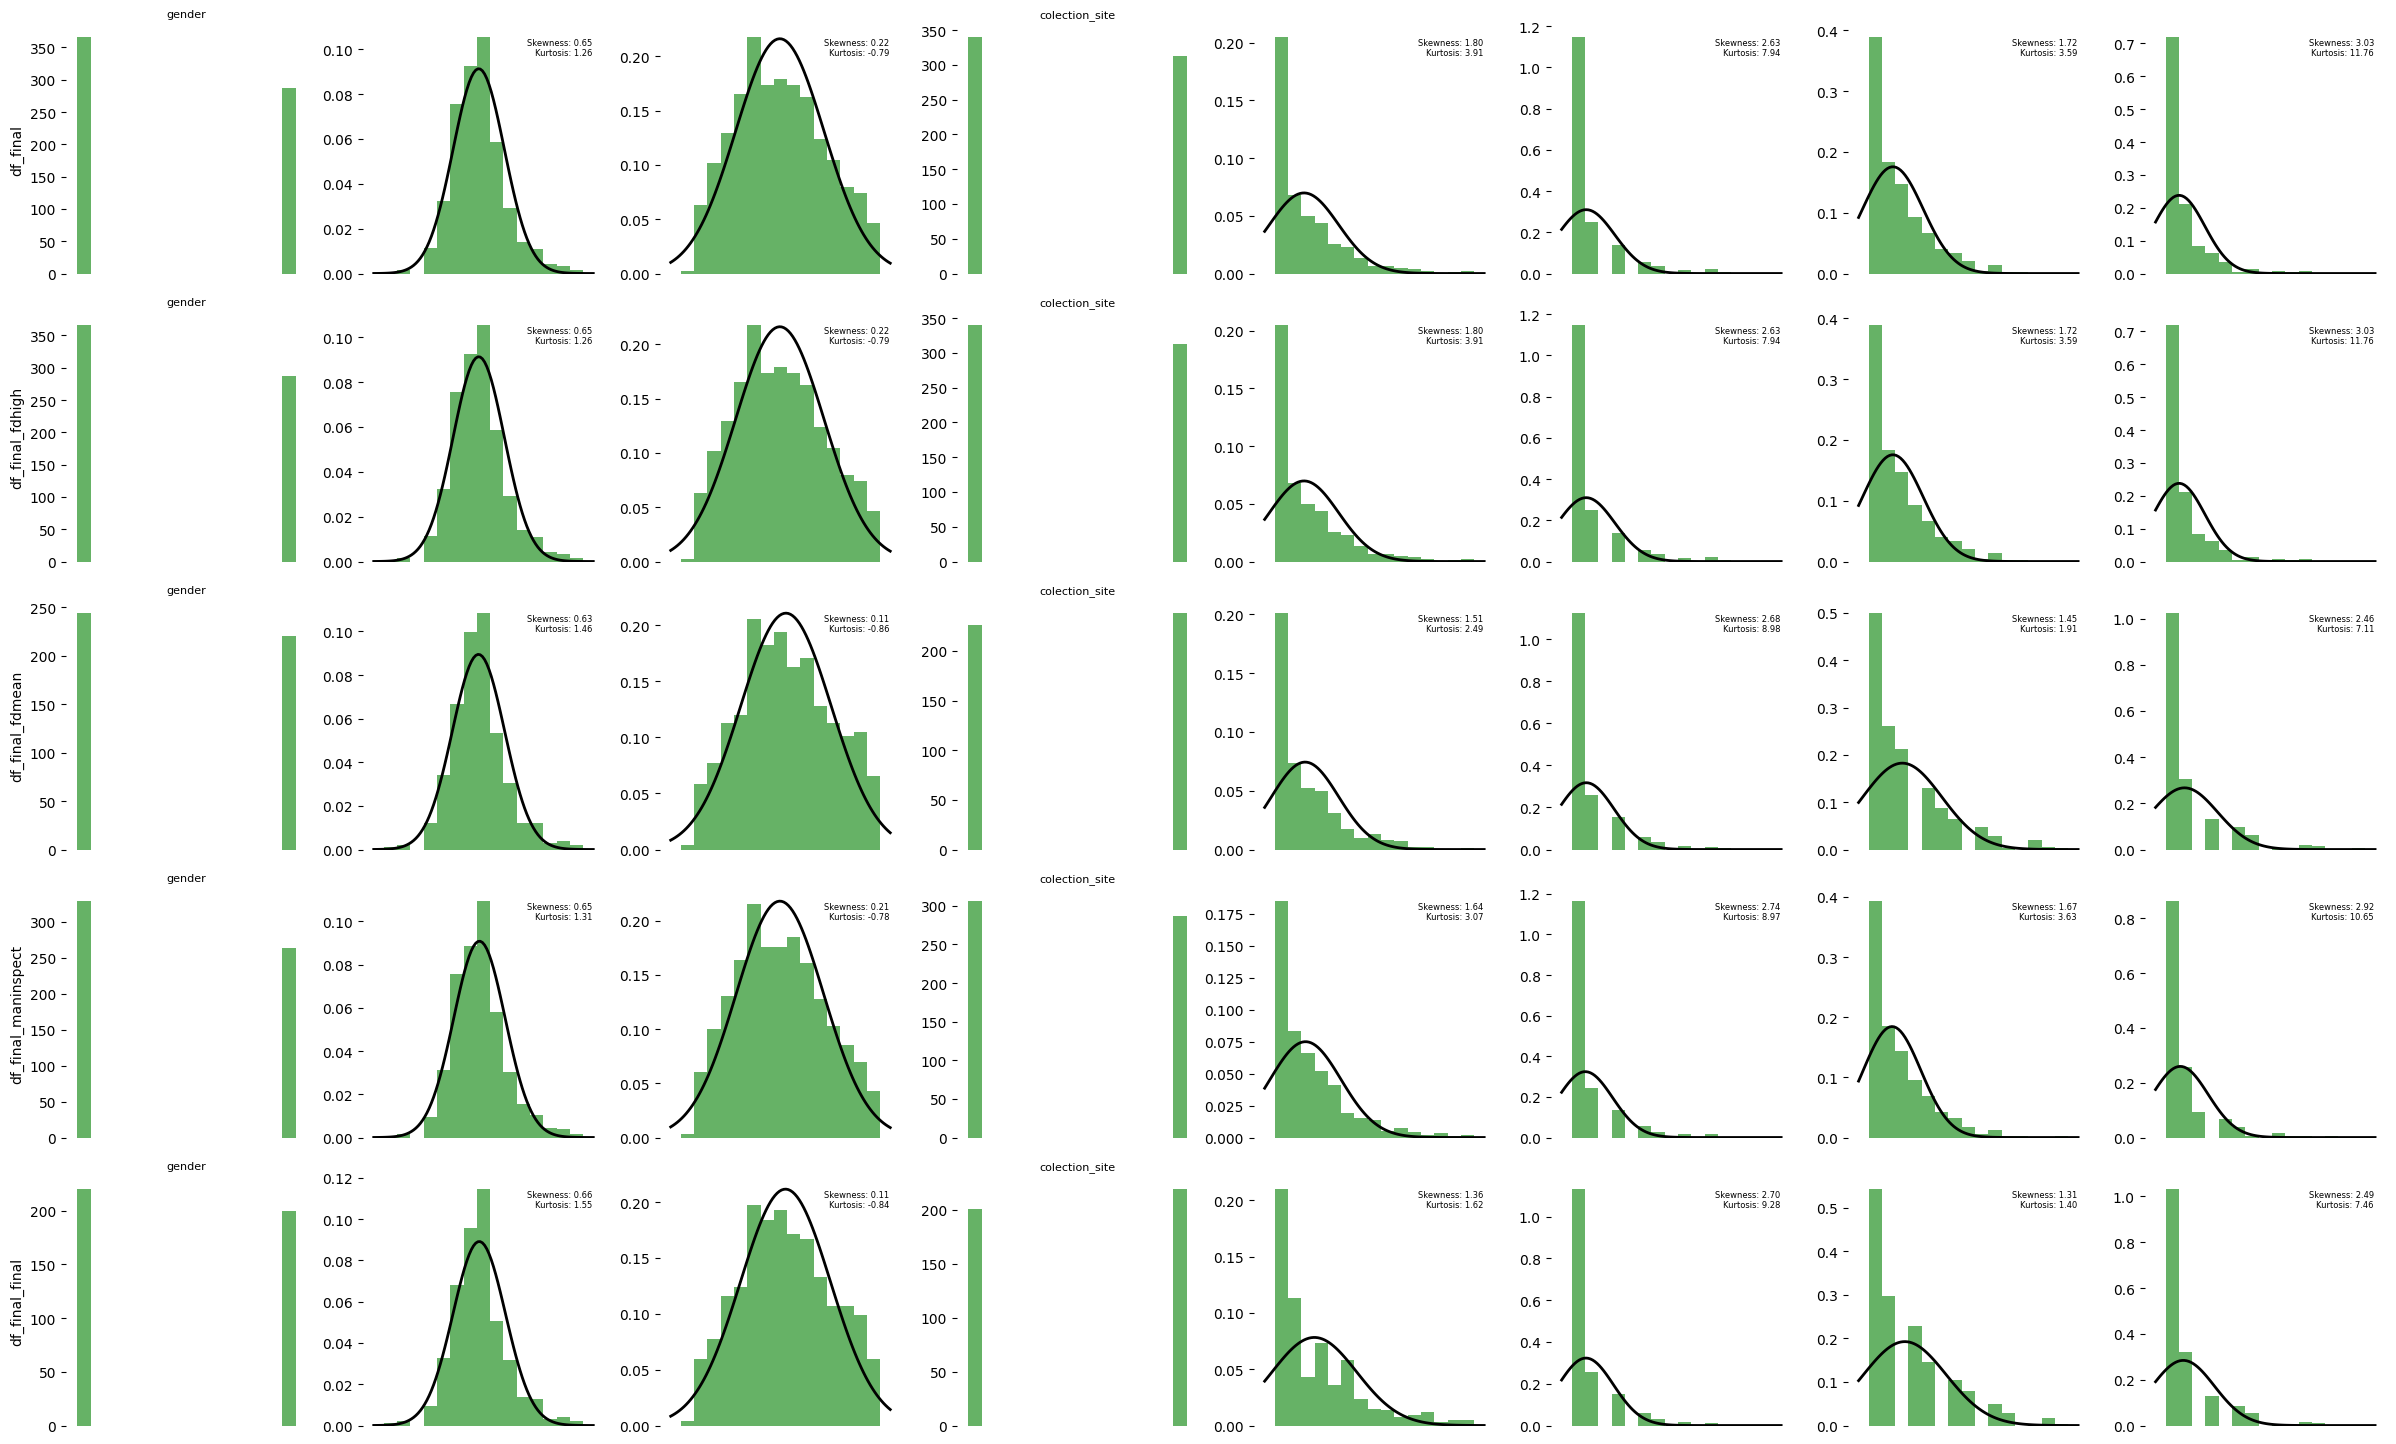

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm, skew, kurtosis

# Definir a figura
plt.figure(figsize=(30,15))

# Lista de títulos para cada DataFrame
titles = ['df_final', 'df_final_fdhigh', 'df_final_fdmean', 'df_final_maninspect', 'df_final_final']

# Variáveis categóricas
variables_categ = ['gender', 'colection_site']

# Iterar sobre os DataFrames e adicionar os gráficos
for idf, data_frame in enumerate([df_final, df_final_fdhigh, df_final_fdmean, df_final_maninspect, df_final_final]):
    for indexx, var in enumerate(['gender', 'abepscore', 'age', 'colection_site', 'cape_tot', 'cape_PA_score', 'cape_PI_score', 'cape_BE_score']):
        
        # Subplot: 5 linhas, 10 colunas
        plt.subplot(5, 10, 10*idf + indexx+1)

        # Obter os dados da variável atual, removendo NaNs
        data = data_frame[var].dropna()

        # Verificar se a variável é categórica
        if var in variables_categ:
            # Plotar apenas o histograma para variáveis categóricas
            plt.hist(data, bins=15, alpha=0.6, color='g', label='Histograma')
            plt.title(f'{var}', fontsize=8)
        else:
            # Para variáveis contínuas, calcular a média e o desvio padrão
            mean = np.mean(data)
            std = np.std(data)

            # Plotar o histograma da variável
            plt.hist(data, bins=15, density=True, alpha=0.6, color='g', label='Histograma')

            # Gerar uma linha de normalidade (curva normal)
            xmin, xmax = plt.xlim()
            x = np.linspace(xmin, xmax, 100)
            p = norm.pdf(x, mean, std)
            plt.plot(x, p, 'k', linewidth=2, label='Curva Normal')

            # Calcular skewness (assimetria) e kurtosis (curtose)
            skewness = skew(data)
            kurt = kurtosis(data)

            # Adicionar os valores de skewness e kurtosis no plot
            plt.text(0.95, 0.95, f'Skewness: {skewness:.2f}\nKurtosis: {kurt:.2f}', 
                     transform=plt.gca().transAxes, fontsize=6, verticalalignment='top', horizontalalignment='right')

        # Adicionar o nome do eixo Y apenas para o primeiro gráfico de cada linha
        if indexx == 0:
            plt.ylabel(titles[idf], fontsize=10)

        # Remover o eixo vertical e os valores do gráfico
        plt.gca().axes.get_xaxis().set_visible(False)  # Esconde o eixo Y
        plt.gca().spines['left'].set_visible(False)    # Remove a linha do eixo Y
        plt.gca().spines['right'].set_visible(False)   # Remove a linha do eixo Y
        plt.gca().spines['top'].set_visible(False)     # Remove a linha do eixo superior
        plt.gca().spines['bottom'].set_visible(False)  # Remove a linha do eixo inferior

# Ajustar o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Deixar espaço no topo para os títulos
plt.show()


In [14]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.utils import resample

# Lista de DataFrames
dfs = [df_final, df_final_fdhigh, df_final_fdmean, df_final_maninspect, df_final_final]
dfs_name = ['df_final', 'df_final_fdhigh', 'df_final_fdmean', 'df_final_maninspect', 'df_final_final']

# Lista de variáveis que você quer comparar
variables_conti = ['abepscore', 'age', 'cape_tot', 'cape_PA_score', 'cape_PI_score', 'cape_BE_score']
variables_categ = ['gender', 'colection_site']

# Função para rodar teste de permutação para variáveis contínuas
def run_permutation_continuous(df1, df2, var, n_permutations=1000):
    # Coletar os valores dos DataFrames para a variável específica
    data1 = df1[var].dropna()
    data2 = df2[var].dropna()
    
    # Estatística observada (diferença de médias)
    observed_diff = np.mean(data1) - np.mean(data2)
    
    # Concatenar os dados
    combined = np.concatenate([data1, data2])
    
    # Inicializar lista para armazenar as diferenças permutadas
    perm_diffs = []
    
    # Realizar as permutações
    for _ in range(n_permutations):
        # Permutar os dados combinados
        permuted = np.random.permutation(combined)
        
        # Repartir os dados permutados
        perm_data1 = permuted[:len(data1)]
        perm_data2 = permuted[len(data1):]
        
        # Calcular a diferença de médias permutada
        perm_diff = np.mean(perm_data1) - np.mean(perm_data2)
        perm_diffs.append(perm_diff)
    
    # Calcular o valor-p
    p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
    
    return observed_diff, p_value

# Função para rodar teste de permutação para variáveis categóricas (Chi2 por permutação)
def run_permutation_categorical(df1, df2, var, n_permutations=1000):
    # Coletar os valores de cada DataFrame
    data1 = df1[var].dropna()
    data2 = df2[var].dropna()
    
    # Montar uma tabela de contingência
    contingency_table = pd.crosstab(data1, data2)
    
    # Verificar se a tabela de contingência contém dados suficientes
    if contingency_table.size == 0:
        return None, None  # Pular se não houver dados suficientes
    
    # Estatística observada (Chi2)
    chi2_stat_observed, _, _, _ = stats.chi2_contingency(contingency_table)
    
    # Concatenar os dados
    combined = pd.concat([data1, data2])
    
    # Inicializar lista para armazenar as estatísticas Chi2 permutadas
    chi2_stats_permuted = []
    
    # Realizar as permutações
    for _ in range(n_permutations):
        # Permutar os rótulos das variáveis categóricas
        perm_data1 = resample(combined, n_samples=len(data1), replace=False).drop_duplicates()
        perm_data2 = resample(combined, n_samples=len(data2), replace=False).drop_duplicates()
        
        # Verificar se ainda há categorias em ambos os conjuntos
        if len(perm_data1.unique()) < 2 or len(perm_data2.unique()) < 2:
            continue  # Pular se uma categoria não existir mais

        # Montar a nova tabela de contingência
        perm_contingency_table = pd.crosstab(perm_data1, perm_data2)
        
        # Verificar se a tabela de contingência contém dados suficientes
        if perm_contingency_table.size == 0:
            continue  # Pular se a tabela estiver vazia
        
        # Calcular a estatística Chi2 permutada
        chi2_stat_perm, _, _, _ = stats.chi2_contingency(perm_contingency_table)
        chi2_stats_permuted.append(chi2_stat_perm)
    
    # Calcular o valor-p
    if len(chi2_stats_permuted) == 0:
        return None, None  # Se não houver permutações válidas
    p_value = np.mean(np.array(chi2_stats_permuted) >= chi2_stat_observed)
    
    return chi2_stat_observed, p_value

# Dicionário para armazenar os resultados
perm_conti_results = {}
perm_categ_results = {}

# Executar o teste de permutação para variáveis contínuas
for i in range(1, len(dfs)):  # Começar de 1 porque o primeiro DataFrame (df_final) é fixo
    df1 = dfs[0]  # df_final
    df2 = dfs[i]  # Comparar com cada outro DataFrame

    # Armazenar resultados para cada variável contínua (permutação)
    for var in variables_conti:
        obs_diff, p_val = run_permutation_continuous(df1, df2, var)
        perm_conti_results[f'{var}_df_final_vs_{dfs_name[i]}'] = {"Observed Diff": obs_diff, "p-value": p_val}

    # Armazenar resultados para cada variável categórica (permutação chi2)
    for var in variables_categ:
        chi2_stat, p_val = run_permutation_categorical(df1, df2, var)
        if chi2_stat is not None and p_val is not None:
            perm_categ_results[f'{var}_df_final_vs_{dfs_name[i]}'] = {"Chi2-statistic": chi2_stat, "p-value": p_val}

# Exibir os resultados de permutação para variáveis contínuas
print("\nPermutation Test Results (Continuous Variables):")
for var, result in perm_conti_results.items():
    print(f"Comparison: {var}")
    print(f"  Observed Difference: {result['Observed Diff']}")
    print(f"  p-value: {result['p-value']}\n")

# Exibir os resultados do teste de permutação para variáveis categóricas
print("\nPermutation Test Results (Categorical Variables):")
for var, result in perm_categ_results.items():
    print(f"Comparison: {var}")
    print(f"  Chi2-statistic: {result['Chi2-statistic']}")
    print(f"  p-value: {result['p-value']}\n")




Permutation Test Results (Continuous Variables):
Comparison: abepscore_df_final_vs_df_final_fdhigh
  Observed Difference: 0.0
  p-value: 1.0

Comparison: age_df_final_vs_df_final_fdhigh
  Observed Difference: 0.0
  p-value: 1.0

Comparison: cape_tot_df_final_vs_df_final_fdhigh
  Observed Difference: 0.0
  p-value: 1.0

Comparison: cape_PA_score_df_final_vs_df_final_fdhigh
  Observed Difference: 0.0
  p-value: 1.0

Comparison: cape_PI_score_df_final_vs_df_final_fdhigh
  Observed Difference: 0.0
  p-value: 1.0

Comparison: cape_BE_score_df_final_vs_df_final_fdhigh
  Observed Difference: 0.0
  p-value: 1.0

Comparison: abepscore_df_final_vs_df_final_fdmean
  Observed Difference: 0.04180968474415181
  p-value: 0.894

Comparison: age_df_final_vs_df_final_fdmean
  Observed Difference: -0.2558423664011915
  p-value: 0.02

Comparison: cape_tot_df_final_vs_df_final_fdmean
  Observed Difference: -0.02206988963404921
  p-value: 0.944

Comparison: cape_PA_score_df_final_vs_df_final_fdmean
  Obser

Exporting

In [13]:
# df_final.to_excel(os.path.join(metadata_path,'variaveis_analise_conf.xlsx'))
# df_final.shape[0]

In [14]:
# n = df_final[['gender', 'abepscore']]